In [2]:
import random
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import panda_gym

import pandas as pd

from tqdm import tqdm

from collections import deque, namedtuple

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress UserWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Suppress DeprecationWarnings


from evotorch import Problem, Solution, SolutionBatch
from evotorch.algorithms import CEM
from evotorch.logging import StdOutLogger

import logging

logging.getLogger("evotorch").disabled = True
logging.getLogger("evotorch").setLevel(logging.ERROR)  # or logging.CRITICAL

from QR_DQN_logger import Logger
from QR_DQN_rl_utils import huber # ReplayMemory, 
import pickle


In [3]:
def save_data(prob, method_name, episodic_rep_returns, mean_episodic_returns, std_episodic_returns):

    np.savez(
    f"{prob}_{method_name}_results.npz",
    episode_rewards=episodic_rep_returns,
    mean_rewards=mean_episodic_returns,
    std_rewards=std_episodic_returns
    )


## Setup


In [4]:
nb_actions = None

Generate random seeds


In [5]:
# nb_rep_episodes = 3
# nb_rep_episodes = 5
# nb_rep_episodes = 1
# random_seeds = np.random.randint(0, 100, nb_rep_episodes)

random_seeds = [0, 8, 15]
print("random_seeds ", type(random_seeds[0]), "\n")
nb_rep_episodes = len(random_seeds)


random_seeds  <class 'int'> 



In [6]:
print("random_seeds ", random_seeds, "\n")


random_seeds  [0, 8, 15] 



Constants

In [7]:
batch_size = 32
num_particles = 100
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)
num_quantiles = len(quantiles)
nb_reps_MPC = 10
nb_random = 0 # 10

Problem setup 


In [8]:
# prob = "CartPole"
# prob = "Acrobot"
prob = "MountainCar"
# prob = "LunarLander"
# prob = "Pendulum"
# prob = "Pendulum_xyomega"
# prob = "MountainCarContinuous"
# prob = "LunarLanderContinuous"
# prob = "PandaReacher"
# prob = "PandaPusher"
# prob = "MuJoCoReacher"
# prob = "MuJoCoPusher"


In [9]:
# env = gym.make('PandaPushDense-v3').unwrapped
# env.reset(), env.action_space.sample(), env.reset()[1]['is_success']

# # env = gym.make('Pusher-v5').unwrapped
# # env.reset(), env.action_space.sample()


In [10]:
if prob == "CartPole":
    discrete = True
    horizon = 30
    max_episodes = 100
    max_steps = 200
    std = None
    change_prob = 0.01
    # change_prob = 0.05
    # change_prob = 0.1
    # change_prob = 0.3
    # change_prob = 0.5
    
    nb_actions = 2
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('CartPole-v0', render_mode="rgb_array").unwrapped # To save time since 200 instead of 500 steps per episode
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = 0 #env.action_space.low[0]
    action_high = 1 # env.action_space.high[0]
    
    goal_state = torch.tensor([0, 0, 0, 0], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-4.8, -torch.inf, -0.41887903, -torch.inf])
    states_high = torch.tensor([4.8, torch.inf, 0.41887903, torch.inf])
    
    def compute_cost_CartPole(states, t, horizon, actions):
        """
        Vectorized cost computation for multiple states and actions.
        
        :param states: Tensor of shape (batch_size, state_dim)
        :param actions: Tensor of shape (batch_size,)
        :return: Cost tensor of shape (batch_size,)
        """
        cart_position = states[:, 0]
        pole_angle = states[:, 2]
        cart_velocity = states[:, 1]
        return pole_angle**2 + 0.1 * cart_position**2 + 0.1 * cart_velocity**2


elif prob == "Acrobot":
    discrete = True
    horizon = 30
    # max_episodes = 300
    max_episodes = 600
    max_steps = 200
    std = None
    change_prob = 0.01
    # change_prob = 0.05
    # change_prob = 0.1
    # change_prob = 0.3
    # change_prob = 0.5
    
    nb_actions = 3
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('Acrobot-v1', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = 0 #env.action_space.low[0]
    action_high = 2 # env.action_space.high[0]
    
    goal_state = torch.tensor([-1, 0, 1, 0, 0, 0], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-1, -1, -1, -1, -12.566371, -28.274334])
    states_high = torch.tensor([1, 1, 1, 1, 12.566371, 28.274334])
    
    def compute_cost_Acrobot(states, t, horizon, actions):
        """
        Compute the cost based on the state and action for the CartPole environment.
        """

        # theta1 = np.arccos(np.clip(states[:, 0],-1,1))  # First joint angle
        # theta2 = np.arccos(np.clip(states[:, 2],-1,1))  # Second joint angle
        
        # distance_to_goal = 1 + (np.cos(theta1) + np.cos(theta1 + theta2))
        
        theta1 = torch.arccos(torch.clip(states[:, 0],-1,1))  # First joint angle
        theta2 = torch.arccos(torch.clip(states[:, 2],-1,1))  # Second joint angle
        
        distance_to_goal = 1 + (torch.cos(theta1) + torch.cos(theta1 + theta2))
        cost = distance_to_goal ** 2
        
        return cost
    

elif prob == "LunarLander": # ToDo
    discrete = True
    horizon = 30
    max_episodes = 400
    # max_steps = 200 # No defined max episode length
    max_steps = 1000
    std = None
    change_prob = 0.01
    # change_prob = 0.05
    # change_prob = 0.1
    # change_prob = 0.3
    # change_prob = 0.5
    
    nb_actions = 3
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('LunarLander-v3', continuous=False, render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = 0 #env.action_space.low[0]
    action_high = 2 # env.action_space.high[0]
    
    goal_state = torch.tensor([0, 0, 0, 0, 0, 0, 1, 1], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-2.5, -2.5, -10, -10, -6.2831855, -10, 0, 0])
    states_high = torch.tensor([2.5, 2.5, 10, 10, 6.2831855, 10, 1, 1])
    
    def compute_cost_LunarLander(states, t, horizon, actions):
        """
        Compute the cost based on the state and action for the CartPole environment.
        """

        x = states[:, 0]
        y = states[:, 1]
        vx = states[:, 2]
        vy = states[:, 3]
        theta = states[:, 4]
        omega = states[:, 5]
        leftcontact = states[:, 6]
        rightcontact = states[:, 7]
        
        cost = x**2 + y**2 + vx**2 + vy**2 + theta**2 + omega**2
        # cost = distance_to_goal ** 2
        
        return cost

elif prob == "MountainCar": # ToDo
    discrete = True
    horizon = 70
    # horizon = 100
    # max_episodes = 100
    max_episodes = 400
    max_steps = 200
    std = None
    # change_prob = 0.01
    # change_prob = 0.05
    change_prob = 0.1
    # change_prob = 0.3
    # change_prob = 0.5
    
    nb_top_particles = 5
    # nb_random = 10

    nb_actions = 3
    
    env = gym.make('MountainCar-v0', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = 0
    action_high = 3
    
    # goal_state = torch.tensor([0, 0, 0, 0], dtype=torch.float32)
    goal_state = torch.tensor([0.5], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-1.2, -0.07])
    states_high = torch.tensor([0.6, 0.07])
    
    def compute_cost_MountainCar(states, t, horizon, actions):
        goal_position = 0.5  # Position goal in Mountain Car
        gamma = 0.90 # 0.0  # Discount factor for delayed rewards
        
        # Distance reward: Encourage progress towards the goal
        distance_reward = (states[:, 0]-goal_position)**2 # -abs(goal_position - state[0])
        
        reverse_discount_factor = gamma**(horizon-t-1)
        
        return reverse_discount_factor*distance_reward 

elif prob == "Pendulum_xyomega":
    discrete = False
    horizon = 15
    max_episodes = 300
    max_steps = 200

    # Current test values
    std = 0
    # std = 3e-1
    # std = 1.5

    # Older test values
    # std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None

    std_string = "0"
    # std_string = "3em1"
    # std_string = "15"
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('Pendulum-v1', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0]
    # state_dim = env.observation_space.shape[0]-1 # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = env.action_space.low[0]
    action_high = env.action_space.high[0]
    
    goal_state = torch.tensor([0, 0], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-1, -1, -8])
    states_high = torch.tensor([1, 1, 8])
    
    def angle_normalize(x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi
    
    def compute_cost_Pendulum_xy_omega(states, t, horizon, actions):
        """
        Vectorized cost function for all particles.

        :param states: Tensor of shape [num_particles, state_dim] containing (theta, omega).
        :param t: Current time step (scalar).
        :param horizon: Planning horizon (scalar).
        :param actions: Tensor of shape [num_particles, 1] (or [num_particles,]) containing actions.
        :return: Tensor of shape [num_particles] with discounted costs.
        """
        gamma = 0.99  # Discount factor

        # Extract theta and omega
        theta = states[:, 0]#.detach().numpy()  # Shape: [num_particles]
        omega = states[:, 1]# .detach().numpy()  # Shape: [num_particles]

        x = states[:, 0]
        y = states[:, 1]
        omega = states[:, 2]
        
        # print("actions.shape ", actions.detach().numpy().reshape(len(actions)).shape, "\n")
        # print("theta.shape ", theta.shape, "\n")
        # print("omega.shape ", omega.shape, "\n")
        # print("actions ", actions, "\n")

        # Normalize theta to [-π, π]
        # theta = (theta + torch.pi) % (2 * torch.pi) - torch.pi 

        # Ensure actions have the correct shape
        # actions = actions.view(-1)  # Flatten to shape [num_particles]

        # Compute cost function
        # cost = theta ** 2 + 0.1 * omega ** 2 + 0.01 * actions.reshape(len(actions)) ** 2
        cost = (1-x)**2 + y**2 + 0.1 * omega**2 + 0.01 * actions.reshape(len(actions)) ** 2

        # Compute discount factor
        reverse_discount_factor = gamma ** (horizon - t - 1)
        
        # print("cost ", cost, "\n")

        return cost * reverse_discount_factor  # Shape: [num_particles]

elif prob == "Pendulum":
    discrete = False
    horizon = 15
    max_episodes = 300
    max_steps = 200

    # Current test values
    std = 0
    # std = 3e-1
    # std = 1.5

    # Older test values
    # std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None

    std_string = "0"
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('Pendulum-v1', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0]-1 # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = env.action_space.low[0]
    action_high = env.action_space.high[0]
    
    goal_state = torch.tensor([0, 0], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-torch.inf, -torch.inf, -8])
    states_high = torch.tensor([torch.inf, torch.inf, 8])
    
    def angle_normalize(x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi
    
    def compute_cost_Pendulum(states, t, horizon, actions):
        """
        Vectorized cost function for all particles.

        :param states: Tensor of shape [num_particles, state_dim] containing (theta, omega).
        :param t: Current time step (scalar).
        :param horizon: Planning horizon (scalar).
        :param actions: Tensor of shape [num_particles, 1] (or [num_particles,]) containing actions.
        :return: Tensor of shape [num_particles] with discounted costs.
        """
        gamma = 0.99  # Discount factor

        # Extract theta and omega
        theta = states[:, 0]#.detach().numpy()  # Shape: [num_particles]
        omega = states[:, 1]# .detach().numpy()  # Shape: [num_particles]
        
        # print("actions.shape ", actions.detach().numpy().reshape(len(actions)).shape, "\n")
        # print("theta.shape ", theta.shape, "\n")
        # print("omega.shape ", omega.shape, "\n")
        # print("actions ", actions, "\n")

        # Normalize theta to [-π, π]
        theta = (theta + torch.pi) % (2 * torch.pi) - torch.pi  

        # Ensure actions have the correct shape
        # actions = actions.view(-1)  # Flatten to shape [num_particles]

        # Compute cost function
        cost = theta ** 2 + 0.1 * omega ** 2 + 0.01 * actions.reshape(len(actions)) ** 2

        # Compute discount factor
        reverse_discount_factor = gamma ** (horizon - t - 1)
        
        # print("cost ", cost, "\n")

        return cost * reverse_discount_factor  # Shape: [num_particles]
    
elif prob == "MountainCarContinuous":
    discrete = False
    horizon = 70
    # horizon = 100
    max_episodes = 100
    max_steps = 300 # 999 # in reality
    # std = 1e-2
    std = 1e-1
    # std = 3e-1
    # std = 6e-1
    change_prob = None
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('MountainCarContinuous-v0', render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 1
    action_low = env.action_space.low[0]
    action_high = env.action_space.high[0]
    
    # goal_state = torch.tensor([0, 0, 0, 0], dtype=torch.float32)
    goal_state = torch.tensor([0.45], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-1.2, -0.07])
    states_high = torch.tensor([0.6, 0.07])
    
    def compute_cost_MountainCarContinuous(states, t, horizon, actions):
        goal_position = 0.45  # Position goal in Mountain Car
        gamma = 0.90 # 0.0  # Discount factor for delayed rewards
        
        # Distance reward: Encourage progress towards the goal
        distance_reward = (states[:, 0]-goal_position)**2 # -abs(goal_position - state[0])
        
        reverse_discount_factor = gamma**(horizon-t-1)
        
        return reverse_discount_factor*distance_reward

elif prob == "LunarLanderContinuous": # ToDo
    discrete = False
    horizon = 30
    max_episodes = 300
    max_steps = 200 # No defined max episode length
    std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('LunarLander-v3', continuous=True, render_mode="rgb_array").unwrapped
    
    # Hyperparameters
    state_dim = env.observation_space.shape[0] # Since we only care about angle and omega which are given using env.state
    # action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
    action_dim = 2
    action_low = -1 #env.action_space.low[0]
    action_high = 1 # env.action_space.high[0]
    
    goal_state = torch.tensor([0, 0, 0, 0, 0, 0, 1, 1], dtype=torch.float32)
    goal_state_dim = len(goal_state)

    states_low = torch.tensor([-2.5, -2.5, -10, -10, -6.2831855, -10, 0, 0])
    states_high = torch.tensor([2.5, 2.5, 10, 10, 6.2831855, 10, 1, 1])
    
    def compute_cost_LunarLanderContinuous(states, t, horizon, actions):
        """
        Compute the cost based on the state and action for the CartPole environment.
        """
        
        x = states[:, 0]
        y = states[:, 1]
        vx = states[:, 2]
        vy = states[:, 3]
        theta = states[:, 4]
        omega = states[:, 5]
        leftcontact = states[:, 6]
        rightcontact = states[:, 7]
        
        cost = x**2 + y**2 + vx**2 + vy**2 + theta**2 + omega**2
        # cost = distance_to_goal ** 2
        
        return cost

elif prob == "PandaReacher":
    discrete = False
    horizon = 15
    max_episodes = 100
    # max_episodes = 400
    max_steps = 50 
    # std = 1e-1
    # std = 3e-1
    # std = 1
    std = 1.5
    change_prob = None

    if std == 1e-1:
        std_string = "1em1"
    elif std == 3e-1:
        std_string = "3em1"
    elif std == 1:
        std_string = "1"
    elif std == 1.5:
        std_string = "15"
    
    goal_state = None # Defined when resetting the env
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('PandaReach-v3', render_mode="rgb_array").unwrapped # Reward only when the end effector is at the goal position
    # env = gym.make('PandaReachDense-v3', render_mode='human').unwrapped # Reward at each time step based on the distance to the goal position
    
    # Hyperparameters    
    actions_low = env.action_space.low#[0] #[:3]
    actions_high = env.action_space.high#[0] #[:3]
    states_low = env.observation_space['observation'].low#[:3]
    states_high = env.observation_space['observation'].high#[:3]
    state_dim = len(states_low)
    action_dim = len(actions_low)
    action_low = actions_low[0]
    action_high = actions_high[0]
    goal_state_dim = 3 #len(states_low)

    states_low = torch.tensor([-10, -10, -10, -10, -10, -10])
    states_high = torch.tensor([10, 10, 10, 10, 10, 10])
    
    def compute_cost_PandaReacher(states, t, horizon, actions, goal_state=None):
        # print("states ", states, "\n")
        # print("states[:, :3] ", states[:, :3], "\n")
        goal_state = torch.tensor(goal_state, dtype=torch.float32, device=states.device).reshape(1, 3)
        costs = torch.norm(states[:, :3] - goal_state, dim=1)

        # print("goal_state ", goal_state, "\n")
        # print("costs ", costs, "\n")
        # print("cost 0 ", torch.norm(states[0, :3]-torch.tensor(goal_state, dtype=torch.float32)), "\n")
        # print("cost 1 ", torch.norm(states[1, :3]-torch.tensor(goal_state, dtype=torch.float32)), "\n")
        return costs
        # torch.norm(states[:, :3]-torch.tensor(goal_state, dtype=torch.float32), dim=1)# +0.1*(torch.norm(actions))**2

elif prob == "PandaPusher": # ToDo
    discrete = False
    horizon = 15
    max_episodes = 100
    max_steps = 50 
    std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None
    
    std_string = "1em1"
    
    goal_state = None # Defined when resetting the env
    
    nb_top_particles = 5
    # nb_random = 10
    
    # env = gym.make("PandaPush-v3").unwrapped # Reward only when the end effector is at the goal position
    env = gym.make('PandaPushDense-v3', render_mode="rgb_array").unwrapped # Reward at each time step based on the distance to the goal position
    
    # Hyperparameters    
    actions_low = env.action_space.low #[:3]
    actions_high = env.action_space.high #[:3]
    states_low = env.observation_space['observation'].low #[:3]
    states_high = env.observation_space['observation'].high #[:3]
    state_dim = len(states_low)
    action_dim = len(actions_low)
    action_low = actions_low[0]
    action_high = actions_high[0]
    goal_state_dim = 3 #len(states_low)

    states_low = torch.tensor([-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10])
    states_high = torch.tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
    
    def compute_cost_PandaPusher(states, t, horizon, actions, goal_state=None):
        # print("goal_state ", goal_state, "\n")
        # print("states[0] ", states[0], "\n")
        # print("states.shape ", states.shape, "\n")
        # print("states[:, :3].shape ", states[:, :3].shape, "\n")
        # print("states[:, 6:9].shape ", states[:, 6:9].shape, "\n")
        
        goal_state = torch.tensor(goal_state, dtype=torch.float32, device=states.device).reshape(1, 3)
        
        costs = torch.norm(states[:, :3]-states[:, 6:9], dim=1)+torch.norm(states[:, 6:9]-goal_state, dim=1)
        
        # print("cost1 ", torch.norm(states[0, :3]-states[0, 6:9])+torch.norm(states[0, 6:9]-goal_state), '\n')
        # print("cost2 ", torch.norm(states[1, :3]-states[1, 6:9])+torch.norm(states[1, 6:9]-goal_state), '\n')
        # print("costs ", costs, "\n")
        
        return costs
    

elif prob == "MuJoCoReacher":
    discrete = False
    horizon = 15
    max_episodes = 400
    max_steps = 50 
    std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None

    if std == 1e-1:
        std_string = "1em1"
    elif std == 3e-1:
        std_string = "3em1"
    elif std == 1:
        std_string = "1"
    elif std == 1.5:
        std_string = "15"
    
    
    goal_state = None # Defined when resetting the env
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('Reacher-v5', render_mode="rgb_array").unwrapped
    
    # Hyperparameters    
    actions_low = env.action_space.low#[:3]
    actions_high = env.action_space.high#[:3]
    # states_low = env.observation_space['observation'].low#[:3]
    # states_high = env.observation_space['observation'].high#[:3]
    state_dim = 8
    action_dim = len(actions_low)
    
    action_low = actions_low[0]
    action_high = actions_high[0]
    
    goal_state_dim = 2

    states_low = torch.tensor([-1, -1, -1, -1, -100, -100, -torch.inf, -torch.inf])
    states_high = torch.tensor([1, 1, 1, 1, 100, 100, torch.inf, torch.inf])
    
    def compute_cost_MuJoCoReacher(states, t, horizon, actions, goal_state=None):
        # cost1 = torch.sqrt(states[0, -2]**2+states[0, -1]**2)+0.1*(torch.norm(actions[0]))**2
        # costs2 = torch.sqrt(states[1, -2]**2+states[1, -1]**2)+0.1*(torch.norm(actions[1]))**2
        costs = torch.sqrt(states[:, -2]**2+states[:, -1]**2)+0.1*(torch.norm(actions, dim=1))**2
        # print("cost1 ", cost1, "\n")
        # print("costs2 ", costs2, "\n")
        # print("costs ", costs, "\n")
        return costs
    # torch.norm(states[:, :3]-torch.tensor(goal_state, dtype=torch.float32))


elif prob == "MuJoCoPusher": # ToDo 
    discrete = False
    horizon = 15
    max_episodes = 100
    max_steps = 50 
    std = 1e-1
    # std = 3e-1
    # std = 1
    # std = 1.5
    change_prob = None
    
    goal_state = None # Defined when resetting the env
    
    nb_top_particles = 5
    # nb_random = 10
    
    env = gym.make('Pusher-v5', render_mode="rgb_array").unwrapped
    
    # Hyperparameters    
    actions_lows = env.action_space.low#[:3]
    actions_highs = env.action_space.high#[:3]
    states_low = env.observation_space['observation'].low#[:3]
    states_high = env.observation_space['observation'].high#[:3]
    state_dim = len(states_low)
    action_dim = len(actions_lows)
    
    action_low = actions_lows[0]
    action_high = actions_highs[0]
    
    goal_state_dim = 3

    # TBD
    states_low = None # torch.tensor([-1, -1, -1, -1, -100, -100, -torch.inf, -torch.inf])
    states_high = None # torch.tensor([1, 1, 1, 1, 100, 100, torch.inf, torch.inf])
    
    def compute_cost_MuJoCoPusher(states, t, horizon, actions, goal_state=None):
        return torch.norm(states[:, 14:17]-states[:, 17:20], dim=1)+torch.norm(states[:, 17:20]-states[:, 20:], dim=1)
        
        # return torch.sqrt(states[:, -2]**2+states[:, -1]**2)+0.1*(torch.norm(actions))**2
    
    # torch.norm(states[:, :3]-torch.tensor(goal_state, dtype=torch.float32))

def compute_cost(prob, states, t, horizon, actions, goal_state=None):
    if prob == "CartPole":
        return compute_cost_CartPole(states, t, horizon, actions)
    elif prob == "Acrobot":
        return compute_cost_Acrobot(states, t, horizon, actions)
    elif prob == "LunarLander":
        return compute_cost_LunarLander(states, t, horizon, actions)
    elif prob == "MountainCar":
        return compute_cost_MountainCar(states, t, horizon, actions)
    elif prob == "Pendulum":
        return compute_cost_Pendulum(states, t, horizon, actions)
    elif prob == "Pendulum_xyomega":
        return compute_cost_Pendulum_xy_omega(states, t, horizon, actions)
    elif prob == "MountainCarContinuous":
        return compute_cost_MountainCarContinuous(states, t, horizon, actions)
    elif prob == "LunarLanderContinuous":
        return compute_cost_LunarLanderContinuous(states, t, horizon, actions)
    elif prob == "PandaReacher":
        return compute_cost_PandaReacher(states, t, horizon, actions, goal_state)
    elif prob == "PandaPusher":
        return compute_cost_PandaPusher(states, t, horizon, actions, goal_state)
    elif prob == "MuJoCoReacher":
        return compute_cost_MuJoCoReacher(states, t, horizon, actions, goal_state)
    elif prob == "MuJoCoPusher":
        return compute_cost_MuJoCoPusher(states, t, horizon, actions, goal_state) 
    else:
        raise ValueError("Unknown problem")


In [11]:
# Only record every 100th episode
def should_record(episode_id):
    return episode_id % 50 == 0



## QR-DQN



In [12]:
class Network(nn.Module):
    def __init__(self, len_state, num_quant, num_actions):
        nn.Module.__init__(self)
        
        self.num_quant = num_quant
        self.num_actions = num_actions
        
        self.layer1 = nn.Linear(len_state, 256)
        self.layer2 = nn.Linear(256, num_actions*num_quant)  

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x.view(-1, self.num_actions, self.num_quant)
    
    def select_action(self, state, eps):
        if not isinstance(state, torch.Tensor): 
            state = torch.Tensor([state])    
        action = torch.randint(0, 2, (1,))
        if random.random() > eps:
            action = self.forward(state).mean(2).max(1)[1]
        return int(action)


In [13]:
def start_QR_DQN(prob, max_episodes, max_steps, seed, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN):
    
    episode_reward_list = []
    
    # print("seed ", seed, "\n")
    # print("env ", env, '\n')
    
    steps_done = 0

    for episode in range(max_episodes):
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        # is_success_bool = False # For Panda Gym envs
        done = False
        actions_list = []
        
        # for step in tqdm(range(max_steps)):
        for step in range(max_steps):
            
            steps_done += 1
            
            action = Z.select_action(torch.Tensor([state]), eps(steps_done))

            action = int(action)
            actions_list.append(action)
            
            # Apply the first action from the optimized sequence
            next_state, reward, done, terminated, info = env.step(action)
            
            memory_QR_DQN.push(state, torch.Tensor([action]), next_state, reward, float(done))
            
            episode_reward += reward
            
            if len(memory_QR_DQN) < batch_size: pass # break
            else:
                # Sample a batch of transitions from replay memory
                states, actions, rewards, next_states, dones = memory_QR_DQN.sample(batch_size)
                # Predicted Q-values for the sampled state-action pairs
                theta = Z(states)[np.arange(batch_size), actions]
                
                # Q-values for the next states using target network
                Znext = Ztgt(next_states).detach()
                # Maximum Q-value for the next states using target network
                Znext_max = Znext[np.arange(batch_size), Znext.mean(2).max(1)[1]]
                
                # Reshape rewards and dones to have shape (batch_size, 1)
                rewards = rewards.view(-1,1)
                dones = dones.view(-1, 1)
                
                # print(rewards.shape, dones.shape, Znext_max.shape, "\n")
                
                # Target value
                Ttheta = rewards + gamma_QR_DQN * (1 - dones) * Znext_max
                # Quantile Huber loss calculation
                diff = Ttheta.t().unsqueeze(-1) - theta 
                loss = huber(diff) * (tau - (diff.detach() < 0).float()).abs()
                loss = loss.mean()

                # Model gradient descent update
                optimizer_QR_DQN.zero_grad()
                loss.backward()
                optimizer_QR_DQN.step()
            
            # Target network update
            if step % 100 == 0:
                Ztgt.load_state_dict(Z.state_dict())
            
            done = done or terminated
            if done:
                # nb_episode_success += 1
                # running_reward = episode_reward  if not running_reward else 0.2 * episode_reward + running_reward*0.8
                break
            
            state = np.copy(next_state).reshape(state_dim)
        
        # episode_reward_list_withASGNN[episode] = episode_reward
        episode_reward_list.append(episode_reward)

    return episode_reward_list

    

In [14]:
def main_QR_DQN(prob, max_episodes, max_steps, random_seeds, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN):
    
    episode_rep_rewards = np.zeros((nb_rep_episodes, max_episodes))
        
    for rep_ep in tqdm(range(nb_rep_episodes)):
    # for seed in tqdm(random_seeds):
        seed = int(random_seeds[rep_ep]) # Seed for episode

        # Wrap the env to record videos into the 'videos/' folder
        # env = RecordVideo(env, video_folder="videos", episode_trigger=should_record, name_prefix=f"{prob}_QR_DQN_seed{seed}")

        episode_reward_list = start_QR_DQN(prob, max_episodes, max_steps, seed, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN)
        
        episode_rep_rewards[rep_ep] = np.array(episode_reward_list).reshape(max_episodes)
        
    mean_episode_rep_rewards = np.mean(episode_rep_rewards, axis=0)
    std_episode_rep_rewards = np.std(episode_rep_rewards, axis=0)

    return episode_rep_rewards, mean_episode_rep_rewards, std_episode_rep_rewards
    
    
    

In [15]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # return random.sample(self.memory, batch_size)
        
        # Sample a batch of transitions
        transitions = random.sample(self.memory, batch_size)
        # Unzip the batch into separate components
        batch = Transition(*zip(*transitions))

        # Convert each component to a tensor
        states = torch.tensor(batch.state, dtype=torch.float32)
        actions = torch.tensor([a.item() if isinstance(a, torch.Tensor) else a for a in batch.action], dtype=torch.long)
        rewards = torch.tensor(batch.reward, dtype=torch.float32)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32)
        dones = torch.tensor(batch.done, dtype=torch.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)




In [16]:
if discrete:
    Z = Network(len_state=len(env.reset()[0]), num_quant=2, num_actions=env.action_space.n)
    Ztgt = Network(len_state=len(env.reset()[0]), num_quant=2, num_actions=env.action_space.n)
    optimizer_QR_DQN = optim.Adam(Z.parameters(), 1e-3)
    
    memory_QR_DQN = ReplayMemory(10000)
    logger_QR_DQN = Logger('q-net', fmt={'loss': '.5f'})
    
    eps_start, eps_end, eps_dec = 0.9, 0.1, 500 
    eps = lambda steps: eps_end + (eps_start - eps_end) * np.exp(-1. * steps / eps_dec)
    gamma_QR_DQN, batch_size_QR_DQN = 0.99, 32
    tau = torch.Tensor((2 * np.arange(Z.num_quant) + 1) / (2.0 * Z.num_quant)).view(1, -1)

    episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN, std_episode_rep_rewards_QR_DQN = main_QR_DQN(prob, max_episodes, max_steps, random_seeds, env, Z, Ztgt, optimizer_QR_DQN, eps_start, eps_end, eps_dec, eps, gamma_QR_DQN, batch_size_QR_DQN, tau, memory_QR_DQN, logger_QR_DQN)





100%|██████████| 3/3 [09:45<00:00, 195.23s/it]


In [17]:
method_name = "QR_DQN"
save_data(prob, method_name, episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN, std_episode_rep_rewards_QR_DQN)




In [18]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")





episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Lunar lander

1000 steps per episode


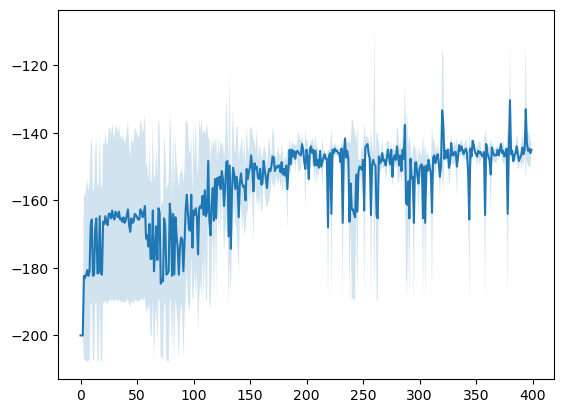

In [19]:
plt.plot(mean_episode_rep_rewards_QR_DQN)
plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [20]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Cart pole

200 steps per episode


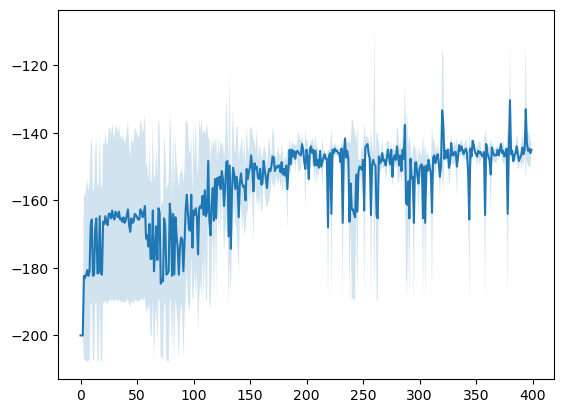

In [21]:
plt.plot(mean_episode_rep_rewards_QR_DQN)
plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [22]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Acrobot

200 steps per episode


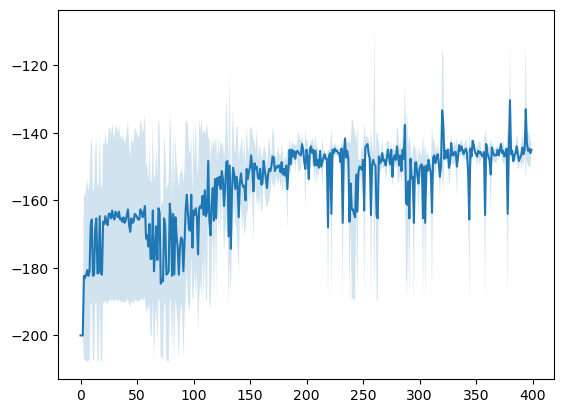

In [23]:
plt.plot(mean_episode_rep_rewards_QR_DQN)
plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [24]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.

- Moutain car

200 steps per episode


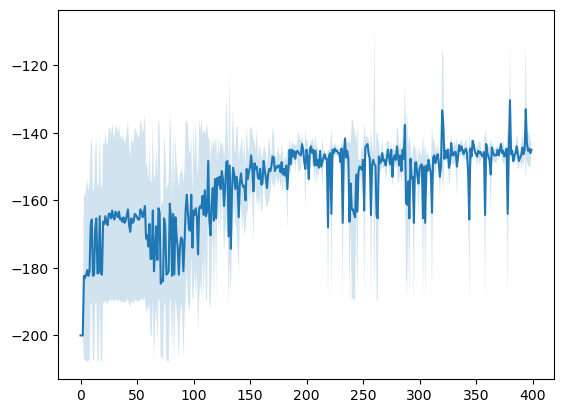

In [25]:
plt.plot(mean_episode_rep_rewards_QR_DQN)
plt.fill_between(np.arange(max_episodes), mean_episode_rep_rewards_QR_DQN-std_episode_rep_rewards_QR_DQN, mean_episode_rep_rewards_QR_DQN+std_episode_rep_rewards_QR_DQN, alpha=0.2)



In [26]:
print("episode_rep_rewards_QR_DQN ", list(episode_rep_rewards_QR_DQN), "\n")
print("mean_episode_rep_rewards_QR_DQN ", list(mean_episode_rep_rewards_QR_DQN), "\n")
print("std_episode_rep_rewards_QR_DQN ", list(std_episode_rep_rewards_QR_DQN), "\n")



episode_rep_rewards_QR_DQN  [array([-200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -200., -200., -200., -200.,
       -200., -200., -200., -200., -200., -177., -200., -200., -196.,
       -200., -199., -200., -200., -189., -200., -200., -200., -183.,
       -193., -200., -185., -200., -186., -184., -200., -193., -200.,
       -184., -200., -181., -200., -200., -157., -200., -200., -189.,
       -172., -200., -167., -200., -159., -175., -162., -177.